Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, GridSearchCV, KFold
from sklearn.linear_model import LogisticRegression, LinearRegression, SGDRegressor
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, BaggingClassifier, RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.svm import LinearSVC, SVR
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import ConfusionMatrixDisplay, f1_score, make_scorer, confusion_matrix, mean_squared_error, mean_absolute_error

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

from xgboost import XGBClassifier, XGBRegressor
from catboost import CatBoostClassifier

from scipy.stats import randint, uniform

import warnings
warnings.filterwarnings("ignore")

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
raw_data = pd.read_csv('../data/raw/WA_Fn-UseC_-Telco-Customer-Churn.csv')

In [20]:
raw_data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [5]:
raw_data.shape

(7043, 21)

In [6]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [7]:
raw_data.isna().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [8]:
raw_data.duplicated().sum()

0

### Data Exploration

Rename the columsn to detailed names and using snake case

In [9]:
# Rename variables to more descriptive snake_case names
column_mapping = {
    'customerID': 'customer_id',
    'gender': 'gender',
    'SeniorCitizen': 'is_senior_citizen',
    'Partner': 'has_partner',
    'Dependents': 'has_dependents',
    'tenure': 'tenure_months',
    'PhoneService': 'has_phone_service',
    'MultipleLines': 'has_multiple_lines',
    'InternetService': 'internet_service_type',
    'OnlineSecurity': 'has_online_security',
    'OnlineBackup': 'has_online_backup',
    'DeviceProtection': 'has_device_protection',
    'TechSupport': 'has_tech_support',
    'StreamingTV': 'has_streaming_tv',
    'StreamingMovies': 'has_streaming_movies',
    'Contract': 'contract_type',
    'PaperlessBilling': 'has_paperless_billing',
    'PaymentMethod': 'payment_method',
    'MonthlyCharges': 'monthly_charges',
    'TotalCharges': 'total_charges',
    'Churn': 'is_churned'
}

# Apply the column renaming
df_renamed = raw_data.rename(columns=column_mapping)

In [19]:
df_renamed.dtypes

customer_id               object
gender                    object
is_senior_citizen          int64
has_partner               object
has_dependents            object
tenure_months              int64
has_phone_service         object
has_multiple_lines        object
internet_service_type     object
has_online_security       object
has_online_backup         object
has_device_protection     object
has_tech_support          object
has_streaming_tv          object
has_streaming_movies      object
contract_type             object
has_paperless_billing     object
payment_method            object
monthly_charges          float64
total_charges             object
is_churned                object
dtype: object

Chanhe the data type of the monthly charges column

In [21]:
df_renamed['total_charges'] = pd.to_numeric(df_renamed['total_charges'], errors='coerce')

In [10]:
df_renamed['gender'].value_counts( normalize=True) * 100

gender
Male      50.47565
Female    49.52435
Name: proportion, dtype: float64

In [11]:
df_renamed['contract_type'].value_counts( normalize=True) * 100

contract_type
Month-to-month    55.019168
Two year          24.066449
One year          20.914383
Name: proportion, dtype: float64

In [12]:
df_renamed['internet_service_type'].value_counts( normalize=True) * 100

internet_service_type
Fiber optic    43.958540
DSL            34.374556
No             21.666903
Name: proportion, dtype: float64

In [13]:
df_renamed['payment_method'].value_counts( normalize=True) * 100

payment_method
Electronic check             33.579441
Mailed check                 22.887974
Bank transfer (automatic)    21.922476
Credit card (automatic)      21.610109
Name: proportion, dtype: float64

In [14]:
df_renamed['is_churned'].value_counts(normalize=True) * 100

is_churned
No     73.463013
Yes    26.536987
Name: proportion, dtype: float64

In [22]:
# Print summary statistics to understand the extent of outliers
df_renamed.describe()

,is_senior_citizen,tenure_months,monthly_charges,total_charges
count,7043.000000,7043.000000,7043.000000,7032.000000
mean,0.162147,32.371149,64.761692,2283.300441
std,0.368612,24.559481,30.090047,2266.771362
min,0.000000,0.000000,18.250000,18.800000
25%,0.000000,9.000000,35.500000,401.450000
50%,0.000000,29.000000,70.350000,1397.475000
75%,0.000000,55.000000,89.850000,3794.737500
max,1.000000,72.000000,118.750000,8684.800000


### Create Train/Test Split
Since no test set is provided by the authoer, we'll hold out a portion of the data as our test set.

In terms of creating our test set, our best option here would be to use stratified sampling to prevent bias. We can do this by creating bins (strata) based on the 'new_claim_value' amount, as non-zero values here imply 'is_claim' is 1 (true) anyway. We can double check this before doing out stratified sampling:

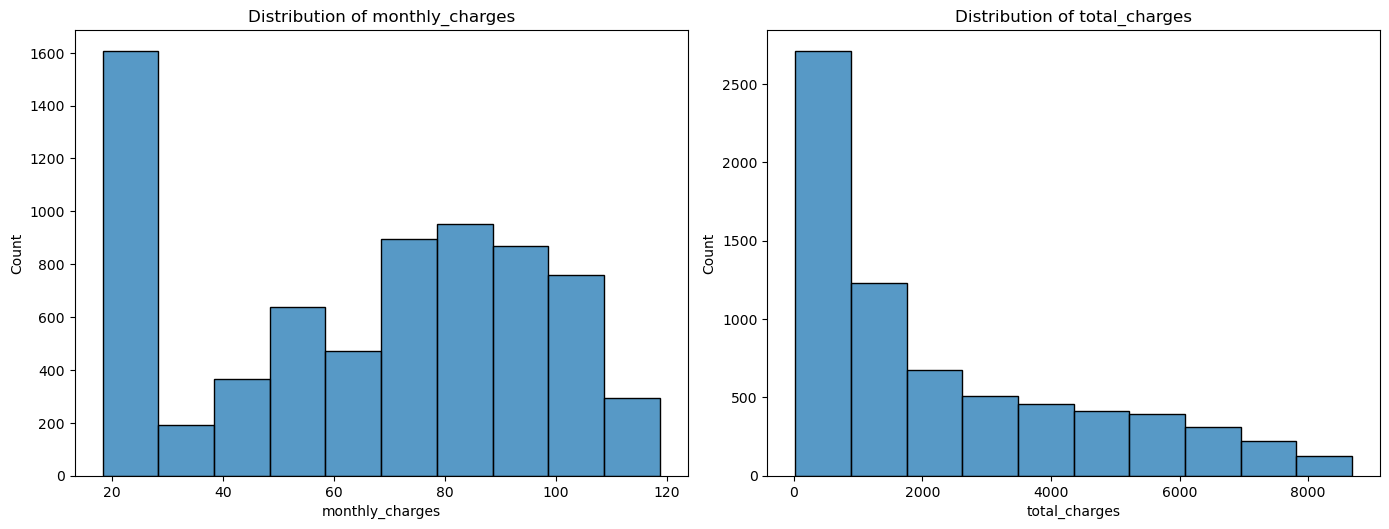

In [ ]:
continuous_vars = ['monthly_charges', 'total_charges']

plt.figure(figsize=(14, 10))
for i, var in enumerate(continuous_vars):
    plt.subplot(2, 2, i+1)
    sns.histplot(df_renamed[var], bins=10)
    plt.title(f'Distribution of {var}')
plt.tight_layout()
plt.show()

In [70]:
df_renamed['monthly_tier'] = pd.cut(
    df_renamed['monthly_charges'],
    bins=[0, 20, 40, 60, 80, 100, 120],
    labels=np.arange(1, 7)
)

<Axes: ylabel='monthly_tier'>

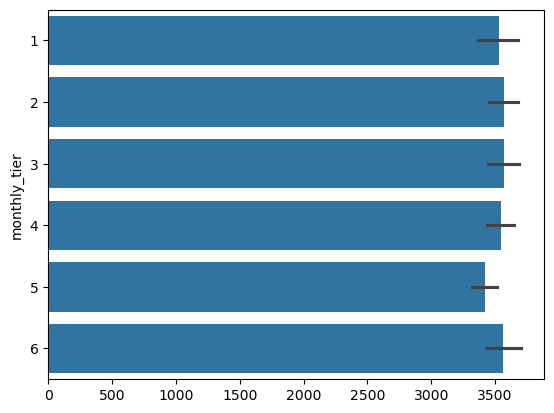

In [71]:
sns.barplot(df_renamed['monthly_tier'])

In [56]:
# Save customer IDs before splitting
customer_ids = df_renamed['customer_id'].copy()

# First, drop columns we don't want to use in modeling
columns_to_drop = ['customer_id', 'total_charges']  # Variables replaced or not needed

# Create feature set and target
X = df_renamed.drop(columns_to_drop + ['is_churned'], axis=1)
y = df_renamed['is_churned']

# Perform stratified train/test split (preserving churn distribution)
X_train, X_test, y_train, y_test, id_train, id_test = train_test_split(
    X, y, customer_ids, test_size=0.2, random_state=42, stratify=y
)

In [60]:
# # Print information about the split
# print(f"Training set: {X_train.shape[0]} samples")
# print(f"Test set: {X_test.shape[0]} samples")
# print(f"Churn rate in training set: {y_train.mean():.2%}")
# print(f"Churn rate in test set: {y_test.mean():.2%}")

# # Step 7: Verify that customer IDs were preserved correctly
# print(f"Number of unique customer IDs in training set: {id_train.nunique()}")
# print(f"Number of unique customer IDs in test set: {id_test.nunique()}")

## Exploratory Data Analysis (EDA)

Preparation

For the purpose of our EDA, we'll join X_train and y_train so we can investigate correlation.

In [61]:
ed_df = pd.DataFrame(X_train, columns=X_train.columns)
ed_df['is_churned'] = y_train

In [64]:
ed_df_renamed = df_renamed.drop(columns_to_drop, axis=1)
ed_df_renamed.head()

,gender,is_senior_citizen,has_partner,has_dependents,tenure_months,has_phone_service,has_multiple_lines,internet_service_type,has_online_security,has_online_backup,has_device_protection,has_tech_support,has_streaming_tv,has_streaming_movies,contract_type,has_paperless_billing,payment_method,monthly_charges,is_churned,monthly_tier,total_tier
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,No,2,1
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,No,3,2
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,Yes,3,1
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,No,3,2
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,Yes,4,1


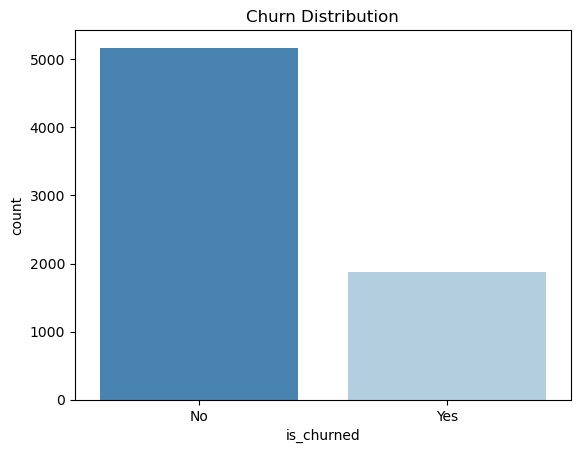

In [65]:
# Univariate Analysis: Distribution of Churn
sns.countplot(data=ed_df_renamed, x='is_churned', palette="Blues_r")
plt.title('Churn Distribution')
plt.show()

1. **Imbalanced Dataset:**
   - Approximately 73% of customers are non-churners vs. 27% churners
   - This imbalance means you'll need to use techniques like SMOTE or class weighting to avoid bias in your models

2. **Business Context:**
   - The churn rate of ~27% is high for a telecom company (industry averages are typically 15-25%)
   - This suggests there are significant opportunities for retention improvements


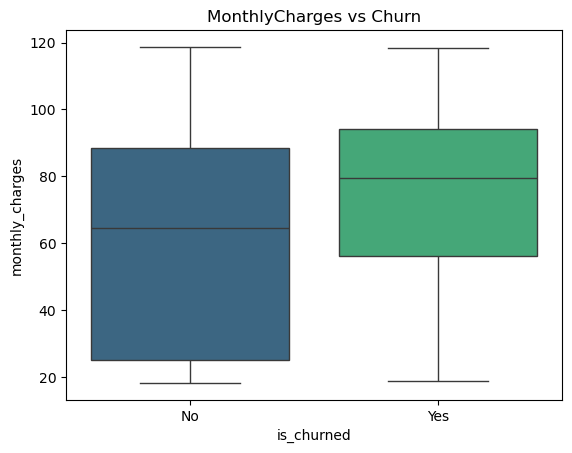

In [66]:
# Bivariate Analysis: MonthlyCharges vs. Churn
sns.boxplot(data=ed_df_renamed, x='is_churned', y='monthly_charges', palette="viridis")
plt.title('MonthlyCharges vs Churn')
plt.show()

1. **Pricing Dynamics:**
   - Churned customers have higher median monthly charges (~$80) compared to loyal customers (~$65)
   - The interquartile range for churners is also higher up the price scale

2. **Customer Price Sensitivity:**
   - The boxplot supports the correlation findings that higher-paying customers are more likely to churn
   - This could indicate price sensitivity or competitors offering better value at higher price points

3. **Retention Strategy Implications:**
   - There appears to be a higher churn risk when monthly charges exceed ~$70-80
   - Both low and high spenders can churn (similar whisker lengths), but high-value customers churn at higher rates

In [69]:
ed_df_renamed.head()

,gender,is_senior_citizen,has_partner,has_dependents,tenure_months,has_phone_service,has_multiple_lines,internet_service_type,has_online_security,has_online_backup,has_device_protection,has_tech_support,has_streaming_tv,has_streaming_movies,contract_type,has_paperless_billing,payment_method,monthly_charges,is_churned,monthly_tier,total_tier
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,No,2,1
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,No,3,2
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,Yes,3,1
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,No,3,2
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,Yes,4,1


In [72]:
# Define binary columns
binary_cols = ['has_partner', 'has_dependents', 'gender', 'has_phone_service','has_online_security',
               'has_online_backup', 'has_device_protection','has_tech_support', 'has_streaming_tv', 
               'has_streaming_movies', 'has_paperless_billing', 'is_churned'
               
               ]

# Define map values
mapping = {'Yes': 1,
           'No': 0,
           'yes': 1,
           'no': 0,
           'Male': 1,
           'Female': 0,
           }

# Define function to binarise features
def binarise_values(data, cols, map):
    for col in cols:
        data[col] = data[col].map(map)
    return data

# Call function
ed_df_renamed = binarise_values(ed_df_renamed, binary_cols, mapping)

In [75]:
ed_df_renamed.corr(numeric_only=True).sort_values(by='is_churned',ascending=False).head()

,gender,is_senior_citizen,has_partner,has_dependents,tenure_months,has_phone_service,has_online_security,has_online_backup,has_device_protection,has_tech_support,has_streaming_tv,has_streaming_movies,has_paperless_billing,monthly_charges,is_churned
is_churned,-0.008612,0.150889,-0.150448,-0.164221,-0.352229,0.011942,-0.280816,-0.196061,-0.177125,-0.274422,-0.037057,-0.040132,0.191825,0.193356,1.000000
monthly_charges,-0.014569,0.220173,0.096848,-0.113890,0.247900,0.247398,0.069118,0.252337,0.321927,0.134233,0.532439,0.525495,0.352150,1.000000,0.193356
has_paperless_billing,-0.011754,0.156530,-0.014877,-0.111377,0.006152,0.016505,-0.139168,0.005437,-0.023632,-0.088224,0.117895,0.100942,1.000000,0.352150,0.191825
is_senior_citizen,-0.001874,1.000000,0.016479,-0.211185,0.016567,0.008576,-0.110473,-0.003577,-0.011482,-0.135584,0.033852,0.050292,0.156530,0.220173,0.150889
has_phone_service,-0.006488,0.008576,0.017706,-0.001762,0.008448,1.000000,-0.038202,0.014718,-0.006211,-0.041421,0.054675,0.043754,0.016505,0.247398,0.011942


<Axes: >

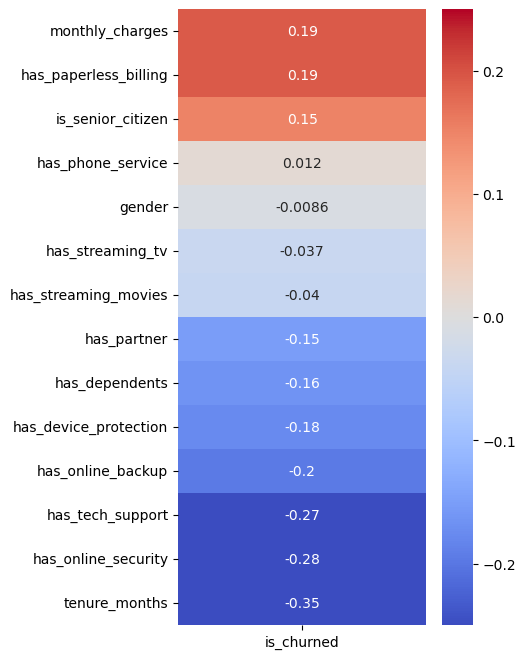

In [74]:
fig, ax = plt.subplots(figsize=(4, 8))

corr_matrix = ed_df_renamed.corr(numeric_only=True).sort_values(by='is_churned',ascending=False)
corr_matrix_no_claim = corr_matrix.drop('is_churned')

sns.heatmap(corr_matrix_no_claim[['is_churned']],cmap='coolwarm', annot=True, vmax=0.25, vmin=-0.25)

1. **Strongest Negative Predictors of Churn:**
   - **Tenure** has the strongest negative correlation (-0.35), indicating that longer-term customers are significantly less likely to churn
   - **Security Features** show strong negative correlations: online security (-0.28) and tech support (-0.27) suggest that customers with these services are more loyal
   - **Backup Services** (-0.20) and device protection (-0.18) also help reduce churn probability

2. **Strongest Positive Predictors of Churn:**
   - **Monthly Charges** (0.19) shows a positive correlation with churn, suggesting higher-paying customers are more likely to leave
   - **Paperless Billing** (0.19) has an equally strong positive correlation with churn
   - **Senior Citizens** (0.15) appear more likely to churn than other age groups

3. **Minimal Impact Factors:**
   - **Gender** (-0.0086) has almost no correlation with churn decisions
   - **Phone Service** (0.012) shows minimal impact on churn

## Strategic Insights

1. **Retention Focus Areas:**
   - Target retention efforts on newer customers (low tenure)
   - Consider promotional offers for security and tech support services, which strongly correlate with loyalty
   - Review pricing strategies for high-value customers who appear most at risk

2. **Product Bundle Opportunities:**
   - Create service bundles that include online security and tech support, which appear to encourage retention
   - Consider family packages since having dependents and partners correlates with lower churn

3. **Model Development Considerations:**
   - Ensure proper handling of the class imbalance during model training
   - Use monthly_charges as a key stratification variable since it shows both correlation with churn and clear segmentation patterns

4. **Customer Segment Targeting:**
   - Focus special retention efforts on senior citizens with high monthly bills
   - Consider incentives to move customers away from paperless billing or create better engagement through digital channels

### Data Cleaning and Preprocessing

Dropping Features

We'll start by dropping the 'red_vehicle' feature, as this showed next to no correlation with the target variable.

In [76]:
ed_df_renamed.head()

,gender,is_senior_citizen,has_partner,has_dependents,tenure_months,has_phone_service,has_multiple_lines,internet_service_type,has_online_security,has_online_backup,has_device_protection,has_tech_support,has_streaming_tv,has_streaming_movies,contract_type,has_paperless_billing,payment_method,monthly_charges,is_churned,monthly_tier,total_tier
0,0,0,1,0,1,0,No phone service,DSL,0.0,1.0,0.0,0.0,0.0,0.0,Month-to-month,1,Electronic check,29.85,0,2,1
1,1,0,0,0,34,1,No,DSL,1.0,0.0,1.0,0.0,0.0,0.0,One year,0,Mailed check,56.95,0,3,2
2,1,0,0,0,2,1,No,DSL,1.0,1.0,0.0,0.0,0.0,0.0,Month-to-month,1,Mailed check,53.85,1,3,1
3,1,0,0,0,45,0,No phone service,DSL,1.0,0.0,1.0,1.0,0.0,0.0,One year,0,Bank transfer (automatic),42.30,0,3,2
4,0,0,0,0,2,1,No,Fiber optic,0.0,0.0,0.0,0.0,0.0,0.0,Month-to-month,1,Electronic check,70.70,1,4,1


In [78]:
df_renamed['has_multiple_lines'].value_counts()

has_multiple_lines
No                  3390
Yes                 2971
No phone service     682
Name: count, dtype: int64

In [ ]:
df_renamed['internet_service_type'].value_counts()

internet_service_type
Fiber optic    3096
DSL            2421
No             1526
Name: count, dtype: int64

In [80]:
df_renamed['contract_type'].value_counts()

contract_type
Month-to-month    3875
Two year          1695
One year          1473
Name: count, dtype: int64

In [ ]:
# Define categorical columns from X_train
cat_cols = X_train.select_dtypes(include=["object", "category"]).columns.tolist()

# Create a ColumnTransformer that applies OneHotEncoder to categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
    ],
    remainder="passthrough"
)

# Create a pipeline with the preprocessor
encoding_pipeline = Pipeline(steps=[("preprocessor", preprocessor)])

# Fit and transform X_train and X_test
X_train_encoded = encoding_pipeline.fit_transform(X_train)
X_test_encoded = encoding_pipeline.transform(X_test)

# Optional: check the resulting shape
print("Shape of X_train_encoded:", X_train_encoded.shape)
print("Shape of X_test_encoded:", X_test_encoded.shape)

In [77]:
X_train_raw = X_train.copy()

cols_to_drop = [
    'gender', 'has_phone_service'
]

X_train_raw.drop(columns=cols_to_drop, axis=1, inplace=True)